# Schneider Electric European Hackathon 2023
## EcoForcast Solution
---
**By:** Jorge Félix Martínez Pazos

**From:** Center for Computational Matemathics Studies. University of Informatics Science.

---

- **This Notebook Contain Mainly the Code, with Just few Analysis.**

- **The Schneider Electric European Hackathon Start and End Time Does Not Allow Deep Analysis and StoryTelling.** 
    - *Mainly Becouse the Deep ETL and Pre-Processing*

### **Introductions**


#### Imports & Configs

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from etl import Start_ETL

import argparse
import datetime
from utils import perform_get_request, xml_to_load_dataframe, xml_to_gen_data

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set_theme(palette='icefire')


### Start Extraction Transform and Load

In [ ]:
Start_ETL()

### Constrains

In [88]:
country_codes = {
        'SP': 'Spain',
        'UK': 'United Kingdom',
        'DE': 'Germany',
        'DK': 'Denmark',
        'HU': 'Hungary',
        'SE': 'Sweden',
        'IT': 'Italy',
        'PO': 'Poland',
        'NE': 'Netherlands'
    }

## Data Processing

### Merged Generation Data

In [310]:
# Load the merged dataset
gdf = pd.read_csv('../data/Processed Data/merged_gen_data.csv', index_col='StartTime', parse_dates=True)
gdf.head(20)

,EndTime,AreaID,UnitName,PsrType,quantity,Country
StartTime,,,,,,
2021-12-31 23:45:00+00:00,2022-01-01T00:00+00:00Z,10Y1001A1001A83F,MAW,Biomass,4333,DE
2022-01-01 00:00:00+00:00,2022-01-01T00:15+00:00Z,10Y1001A1001A83F,MAW,Biomass,4325,DE
2022-01-01 00:15:00+00:00,2022-01-01T00:30+00:00Z,10Y1001A1001A83F,MAW,Biomass,4319,DE
2022-01-01 00:30:00+00:00,2022-01-01T00:45+00:00Z,10Y1001A1001A83F,MAW,Biomass,4323,DE
2022-01-01 00:45:00+00:00,2022-01-01T01:00+00:00Z,10Y1001A1001A83F,MAW,Biomass,4328,DE
2022-01-01 01:00:00+00:00,2022-01-01T01:15+00:00Z,10Y1001A1001A83F,MAW,Biomass,4322,DE
2022-01-01 01:15:00+00:00,2022-01-01T01:30+00:00Z,10Y1001A1001A83F,MAW,Biomass,4331,DE
2022-01-01 01:30:00+00:00,2022-01-01T01:45+00:00Z,10Y1001A1001A83F,MAW,Biomass,4335,DE
2022-01-01 01:45:00+00:00,2022-01-01T02:00+00:00Z,10Y1001A1001A83F,MAW,Biomass,4334,DE


In [311]:
gdf['UnitName'].value_counts()

MAW    2747847
Name: UnitName, dtype: int64

In [312]:
gdf.any().isna()

EndTime     False
AreaID      False
UnitName    False
PsrType     False
quantity    False
Country     False
dtype: bool

As see nbefore all values are in the same unit MAW, and there is no missing value within the data

In [313]:
gdf['Country'].value_counts()

NE    700800
DE    665759
SP    498246
HU    490560
IT    125160
PO     96360
DK     70069
SE     53585
UK     47308
Name: Country, dtype: int64

#### DF Reshape
Reshaping dataframe to turn each Green Energy type into a columns

In [314]:
import pandas as pd

def reshape_dataframe(df):
    # Asegurarse de que el índice es de tipo datetime
    df.index = pd.to_datetime(df.index)

    # Pivotar el DataFrame para tener los valores de 'PsrType' como columnas
    df_pivot = df.pivot_table(index=[df.index, 'Country'], columns='PsrType', values='quantity')

    # Resetear el índice para que 'Country' sea una columna
    df_pivot.reset_index(level='Country', inplace=True)

    # Rellenar los valores NaN con 0.0
    df_pivot.fillna(0.0, inplace=True)

    return df_pivot

# Usar la función en tu DataFrame
rs_gdf = reshape_dataframe(gdf)


In [315]:
rs_gdf['Country'].value_counts()

DE    35040
HU    35040
NE    35040
SP    24816
DK     8760
IT     8760
PO     8760
SE     8759
UK     6322
Name: Country, dtype: int64

In [316]:
rs_gdf.any().isna()

PsrType
Country                            False
Biomass                            False
Fossil Brown coal/Lignite          False
Fossil Coal-derived gas            False
Fossil Gas                         False
Fossil Hard coal                   False
Fossil Oil                         False
Fossil Oil shale                   False
Fossil Peat                        False
Geothermal                         False
Hydro Pumped Storage               False
Hydro Run-of-river and poundage    False
Hydro Water Reservoir              False
Marine                             False
Nuclear                            False
Other                              False
Other renewable                    False
Solar                              False
Waste                              False
Wind Offshore                      False
Wind Onshore                       False
dtype: bool

In [317]:
rs_gdf.head()

PsrType,Country,Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Fossil Oil shale,Fossil Peat,Geothermal,...,Hydro Run-of-river and poundage,Hydro Water Reservoir,Marine,Nuclear,Other,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
StartTime,,,,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,DK,468.0,0.0,0.0,215.0,331.0,37.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1875.0,1308.0
2021-12-31 23:00:00+00:00,IT,677.0,0.0,517.0,6234.0,1465.0,202.0,0.0,0.0,639.0,...,2115.0,242.0,0.0,0.0,1365.0,0.0,0.0,36.0,0.0,2024.0
2021-12-31 23:00:00+00:00,PO,221.0,2422.0,64.0,996.0,5685.0,280.0,0.0,0.0,0.0,...,176.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4244.0
2021-12-31 23:00:00+00:00,SE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7015.0,0.0,5842.0,1265.0,0.0,0.0,0.0,0.0,4045.0
2021-12-31 23:00:00+00:00,SP,533.0,0.0,0.0,3874.0,847.0,121.0,0.0,0.0,0.0,...,1082.0,1347.0,0.0,6091.0,50.0,98.0,75.0,268.0,0.0,6398.0


In [318]:
rs_gdf.columns

Index(['Country', 'Biomass', 'Fossil Brown coal/Lignite',
       'Fossil Coal-derived gas', 'Fossil Gas', 'Fossil Hard coal',
       'Fossil Oil', 'Fossil Oil shale', 'Fossil Peat', 'Geothermal',
       'Hydro Pumped Storage', 'Hydro Run-of-river and poundage',
       'Hydro Water Reservoir', 'Marine', 'Nuclear', 'Other',
       'Other renewable', 'Solar', 'Waste', 'Wind Offshore', 'Wind Onshore'],
      dtype='object', name='PsrType')

#### Drop No Green Energies

In [320]:
No_Green_Energy = ['Fossil Brown coal/Lignite', 'Fossil Coal-derived gas', 'Fossil Gas',
                   'Fossil Hard coal', 'Fossil Oil', 'Fossil Oil shale', 'Fossil Peat',
                   'Nuclear', 'Other']


In [321]:
new_gdf = rs_gdf.drop(No_Green_Energy, axis=1)
new_gdf

PsrType,Country,Biomass,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Marine,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
StartTime,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,DK,468.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1875.0,1308.0
2021-12-31 23:00:00+00:00,IT,677.0,639.0,52.0,2115.0,242.0,0.0,0.0,0.0,36.0,0.0,2024.0
2021-12-31 23:00:00+00:00,PO,221.0,0.0,0.0,176.0,0.0,0.0,0.0,0.0,0.0,0.0,4244.0
2021-12-31 23:00:00+00:00,SE,0.0,0.0,0.0,0.0,7015.0,0.0,0.0,0.0,0.0,0.0,4045.0
2021-12-31 23:00:00+00:00,SP,533.0,0.0,1711.0,1082.0,1347.0,0.0,98.0,75.0,268.0,0.0,6398.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:15:00+00:00,SP,168.0,0.0,1482.0,936.0,2164.0,0.0,80.0,20.0,228.0,0.0,6112.0
2022-12-31 23:30:00+00:00,DE,4357.0,27.0,1057.5,1201.0,85.0,0.0,103.0,0.0,731.0,3258.0,14208.5
2022-12-31 23:30:00+00:00,HU,110.0,0.0,0.0,9.0,0.0,0.0,11.0,0.0,14.0,0.0,66.0


In [322]:
new_gdf.any().isna()

PsrType
Country                            False
Biomass                            False
Geothermal                         False
Hydro Pumped Storage               False
Hydro Run-of-river and poundage    False
Hydro Water Reservoir              False
Marine                             False
Other renewable                    False
Solar                              False
Waste                              False
Wind Offshore                      False
Wind Onshore                       False
dtype: bool

## Time Resolutions

In [323]:

def Time_Resolutions(df):
    
    df.index = pd.to_datetime(df.index)

    # Crear un diccionario para almacenar las series de tiempo para cada país
    series_tiempo = {}

    # Crear una serie de tiempo para cada país
    for pais in df['Country'].unique():
        series_tiempo[pais] = df[df['Country'] == pais].index.to_series()

    # Calcular e imprimir las resoluciones de tiempo para cada país
    for pais, serie in series_tiempo.items():
        print(f'Country: {pais}')
        print('Time Resolutions (in minutes):')
        diff = serie.diff().dt.total_seconds() / 60
        print(diff[~np.isnan(diff)].unique())  # Eliminar los valores NaN antes de imprimir

In [324]:
Time_Resolutions(new_gdf)

Country: DK
Time Resolutions (in minutes):
[60.]
Country: IT
Time Resolutions (in minutes):
[60.]
Country: PO
Time Resolutions (in minutes):
[60.]
Country: SE
Time Resolutions (in minutes):
[ 60. 120.]
Country: SP
Time Resolutions (in minutes):
[ 60. 105.  15.]
Country: DE
Time Resolutions (in minutes):
[15.]
Country: HU
Time Resolutions (in minutes):
[15.]
Country: NE
Time Resolutions (in minutes):
[15.]
Country: UK
Time Resolutions (in minutes):
[3.0000e+01 1.4700e+03 9.0000e+01 2.8293e+05 9.0300e+03 2.7000e+02
 2.1000e+02 1.5000e+02 3.3000e+02]


In [325]:
def resample_to_1h_per_country(df):
    """
    This function resamples a DataFrame to a time resolution of 1 hour for each country separately and sums up the values of each type of energy.

    Parameters:
    df (pandas.DataFrame): The input DataFrame. It is assumed that the DataFrame's index is of type datetime and that there is a 'Country' column.

    Returns:
    df_resampled (pandas.DataFrame): The resampled DataFrame.
    """

    # Create a dictionary to store the resampled DataFrames for each country
    dfs_resampled = {}

    # For each country in the DataFrame, resample to a time resolution of 1 hour and sum the values
    for country in df['Country'].unique():
        df_country = df[df['Country'] == country]
        df_country_resampled = df_country.resample('1H').sum()

        # Add the 'Country' column to the resampled DataFrame
        df_country_resampled['Country'] = country

        dfs_resampled[country] = df_country_resampled

    # Concatenate all the resampled DataFrames into a single DataFrame
    df_resampled = pd.concat(dfs_resampled.values())

    return df_resampled

# Use the function on your DataFrame
gdf_resampled = resample_to_1h_per_country(new_gdf)
gdf_resampled



PsrType,Biomass,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Marine,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore,Country
StartTime,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,468.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1875.0,1308.0,DK
2022-01-01 00:00:00+00:00,511.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1904.0,1189.0,DK
2022-01-01 01:00:00+00:00,519.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1738.0,1051.0,DK
2022-01-01 02:00:00+00:00,558.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1436.0,1048.0,DK
2022-01-01 03:00:00+00:00,468.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1505.0,878.0,DK
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,412.0,UK
2022-12-31 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,415.0,UK
2022-12-31 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,338.0,UK


In [326]:
Time_Resolutions(gdf_resampled)

Country: DK
Time Resolutions (in minutes):
[60.]
Country: IT
Time Resolutions (in minutes):
[60.]
Country: PO
Time Resolutions (in minutes):
[60.]
Country: SE
Time Resolutions (in minutes):
[60.]
Country: SP
Time Resolutions (in minutes):
[60.]
Country: DE
Time Resolutions (in minutes):
[60.]
Country: HU
Time Resolutions (in minutes):
[60.]
Country: NE
Time Resolutions (in minutes):
[60.]
Country: UK
Time Resolutions (in minutes):
[60.]


In [327]:
gdf_resampled['Country'].value_counts()

SP    8761
DE    8761
HU    8761
NE    8761
DK    8760
IT    8760
PO    8760
SE    8760
UK    8137
Name: Country, dtype: int64

### Same Processing for Merged Load Data

In [328]:
ldf = pd.read_csv('../data/Processed Data/merged_load_data.csv', index_col='StartTime', parse_dates=True)
ldf.head(20)

,EndTime,AreaID,UnitName,Load,Country
StartTime,,,,,
2021-12-31 23:45:00+00:00,2022-01-01T00:00+00:00Z,10Y1001A1001A83F,MAW,42196,DE
2022-01-01 00:00:00+00:00,2022-01-01T00:15+00:00Z,10Y1001A1001A83F,MAW,41804,DE
2022-01-01 00:15:00+00:00,2022-01-01T00:30+00:00Z,10Y1001A1001A83F,MAW,41141,DE
2022-01-01 00:30:00+00:00,2022-01-01T00:45+00:00Z,10Y1001A1001A83F,MAW,41002,DE
2022-01-01 00:45:00+00:00,2022-01-01T01:00+00:00Z,10Y1001A1001A83F,MAW,41178,DE
2022-01-01 01:00:00+00:00,2022-01-01T01:15+00:00Z,10Y1001A1001A83F,MAW,40635,DE
2022-01-01 01:15:00+00:00,2022-01-01T01:30+00:00Z,10Y1001A1001A83F,MAW,40162,DE
2022-01-01 01:30:00+00:00,2022-01-01T01:45+00:00Z,10Y1001A1001A83F,MAW,39948,DE
2022-01-01 01:45:00+00:00,2022-01-01T02:00+00:00Z,10Y1001A1001A83F,MAW,39670,DE


In [329]:
ldf['UnitName'].value_counts()

MAW    174322
Name: UnitName, dtype: int64

In [330]:
ldf['Country'].value_counts()

DE    35040
HU    35040
NE    35040
SP    24816
UK     9346
DK     8760
IT     8760
PO     8760
SE     8760
Name: Country, dtype: int64

In [331]:
Time_Resolutions(ldf)

Country: DE
Time Resolutions (in minutes):
[15.]
Country: DK
Time Resolutions (in minutes):
[60.]
Country: HU
Time Resolutions (in minutes):
[15.]
Country: IT
Time Resolutions (in minutes):
[60.]
Country: NE
Time Resolutions (in minutes):
[15.]
Country: PO
Time Resolutions (in minutes):
[60.]
Country: SE
Time Resolutions (in minutes):
[60.]
Country: SP
Time Resolutions (in minutes):
[ 60. 105.  15.]
Country: UK
Time Resolutions (in minutes):
[ 30. 150.  90. 510. 210.]


In [332]:
ldf_resampled = resample_to_1h_per_country(ldf)
ldf_resampled

,Load,Country
StartTime,,
2021-12-31 23:00:00+00:00,42196,DE
2022-01-01 00:00:00+00:00,165125,DE
2022-01-01 01:00:00+00:00,160415,DE
2022-01-01 02:00:00+00:00,158035,DE
2022-01-01 03:00:00+00:00,157016,DE
...,...,...
2022-07-17 22:00:00+00:00,1294,UK
2022-07-17 23:00:00+00:00,1185,UK
2022-07-18 00:00:00+00:00,1117,UK


In [333]:
Time_Resolutions(ldf_resampled)

Country: DE
Time Resolutions (in minutes):
[60.]
Country: DK
Time Resolutions (in minutes):
[60.]
Country: HU
Time Resolutions (in minutes):
[60.]
Country: IT
Time Resolutions (in minutes):
[60.]
Country: NE
Time Resolutions (in minutes):
[60.]
Country: PO
Time Resolutions (in minutes):
[60.]
Country: SE
Time Resolutions (in minutes):
[60.]
Country: SP
Time Resolutions (in minutes):
[60.]
Country: UK
Time Resolutions (in minutes):
[60.]


In [334]:
ldf_resampled['Country'].value_counts()

DE    8761
HU    8761
NE    8761
SP    8761
DK    8760
IT    8760
PO    8760
SE    8760
UK    4756
Name: Country, dtype: int64

### Concat Generation and Load Energy DataFrames

In [335]:
def combine_dataframes(df_gen, df_load, filename):
    """
    This function combines two DataFrames into one, keeping the same timestamp and adding the 'Load' column to the generation DataFrame.

    Parameters:
    df_gen (pandas.DataFrame): The energy generation DataFrame.
    df_load (pandas.DataFrame): The energy load DataFrame.
    filename (str): The name of the CSV file where the combined DataFrame will be saved.

    Returns:
    df_combined (pandas.DataFrame): The combined DataFrame.
    """

    # Reset the index of both DataFrames
    df_gen = df_gen.reset_index()
    df_load = df_load.reset_index()

    # Combine the two DataFrames into one
    df_combined = pd.merge(df_gen, df_load, on=['StartTime', 'Country'], how='outer')

    # Set 'StartTime' as the index again
    df_combined.set_index('StartTime', inplace=True)

    # Define the green energy columns
    green_energy_columns = ['Biomass', 'Geothermal', 'Hydro Pumped Storage', 
                        'Hydro Run-of-river and poundage', 'Hydro Water Reservoir', 
                        'Marine', 'Other renewable', 'Solar', 'Wind Offshore', 'Wind Onshore']

    # Create a new column 'GE' which is the sum of all the green energy columns
    df_combined['GE'] = df_combined[green_energy_columns].sum(axis=1)

    # Define the column order
    column_order = ['Country', 'Load', 'GE'] + [col for col in df_combined.columns if col not in ['Country', 'Load', 'GE']]

    # Rearrange the columns
    df_combined = df_combined[column_order]

    # Save the combined DataFrame to a CSV file
    #df_combined.to_csv(filename)


    return df_combined


# Use the function on your DataFrames
df_combined = combine_dataframes(gdf_resampled, ldf_resampled, '../data/procesed_data/Full_Data.csv')


In [336]:
df_combined.head(20)

,Country,Load,GE,Biomass,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Marine,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
StartTime,,,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,DK,3314.0,3652.0,468.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1875.0,1308.0
2022-01-01 00:00:00+00:00,DK,3218.0,3605.0,511.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1904.0,1189.0
2022-01-01 01:00:00+00:00,DK,3126.0,3309.0,519.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1738.0,1051.0
2022-01-01 02:00:00+00:00,DK,3080.0,3043.0,558.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1436.0,1048.0
2022-01-01 03:00:00+00:00,DK,3044.0,2852.0,468.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1505.0,878.0
2022-01-01 04:00:00+00:00,DK,3130.0,2724.0,505.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,168.0,1391.0,827.0
2022-01-01 05:00:00+00:00,DK,3238.0,2579.0,554.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,165.0,1407.0,617.0
2022-01-01 06:00:00+00:00,DK,3378.0,2293.0,720.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,170.0,1098.0,474.0
2022-01-01 07:00:00+00:00,DK,3537.0,1806.0,714.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,171.0,734.0,346.0


In [337]:
df_combined['Country'].value_counts()

SP    8761
DE    8761
HU    8761
NE    8761
UK    8761
DK    8760
IT    8760
PO    8760
SE    8760
Name: Country, dtype: int64

In [338]:
df = df_combined
df

,Country,Load,GE,Biomass,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Marine,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
StartTime,,,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,DK,3314.0,3652.0,468.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1875.0,1308.0
2022-01-01 00:00:00+00:00,DK,3218.0,3605.0,511.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1904.0,1189.0
2022-01-01 01:00:00+00:00,DK,3126.0,3309.0,519.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1738.0,1051.0
2022-01-01 02:00:00+00:00,DK,3080.0,3043.0,558.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1436.0,1048.0
2022-01-01 03:00:00+00:00,DK,3044.0,2852.0,468.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,1505.0,878.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-26 18:00:00+00:00,UK,2728.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-26 19:00:00+00:00,UK,2518.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-26 20:00:00+00:00,UK,2339.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Reshape & Melt the DataFrame
In order to get **GE_CountryCode**, **Load_CountryCode** columns.

In [339]:
def reshape_df(df):
    """
    Esta función reformatea el DataFrame de entrada y devuelve un nuevo DataFrame con 'StartTime' como índice y columnas para 'GE' y 'Load' para cada país.

    Parámetros:
    df (pandas.DataFrame): El DataFrame de entrada.

    Devoluciones:
    result (pandas.DataFrame): El DataFrame reformateado.
    """

    # Resetear el índice para hacer 'StartTime' una columna
    df = df.reset_index()

    # Derretir el DataFrame para tener 'Country', 'variable' (Load o GE) y 'value' como columnas
    df_melt = df.melt(id_vars=['StartTime', 'Country'], value_vars=['Load', 'GE'])

    # Crear una nueva columna 'variable_country' que es la concatenación de 'variable' y 'Country'
    df_melt['variable_country'] = df_melt['variable'] + '_' + df_melt['Country']

    # Pivotar el DataFrame para obtener columnas para 'Load' y 'GE' para cada país
    result = df_melt.pivot(index='StartTime', columns='variable_country', values='value')

    return result

# Usar la función en tu DataFrame
result = reshape_df(df)
result


variable_country,GE_DE,GE_DK,GE_HU,GE_IT,GE_NE,GE_PO,GE_SE,GE_SP,GE_UK,Load_DE,Load_DK,Load_HU,Load_IT,Load_NE,Load_PO,Load_SE,Load_SP,Load_UK
StartTime,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,25558.5,3652.0,285.0,5749.0,1777.0,4641.0,11060.0,11244.0,0.0,42196.0,3314.0,4254.0,21121.0,10326.0,14438.0,15331.0,20827.0,677.0
2022-01-01 00:00:00+00:00,102228.0,3605.0,1376.0,5679.5,6384.0,4491.0,11107.0,10827.0,0.0,165125.0,3218.0,16457.0,19756.0,40706.0,13935.0,15331.0,19530.0,1244.0
2022-01-01 01:00:00+00:00,98646.0,3309.0,1526.0,5878.0,5565.5,4436.0,11036.0,11140.0,0.0,160415.0,3126.0,15426.0,18685.0,39465.0,13579.0,15270.0,18383.0,1131.0
2022-01-01 02:00:00+00:00,96781.5,3043.0,1560.0,6039.5,5662.0,4568.0,10509.0,11361.0,0.0,158035.0,3080.0,14781.0,18124.0,38923.0,13397.0,15150.0,17680.0,1091.0
2022-01-01 03:00:00+00:00,93765.0,2852.0,1287.0,5593.0,5645.0,4559.0,10770.0,11247.0,0.0,157016.0,3044.0,14630.0,18400.0,38211.0,13364.0,15387.0,17396.0,969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,108172.5,1765.0,851.0,4157.0,8620.5,6959.0,10179.0,62510.0,412.0,184106.0,3713.0,17488.0,24809.0,45646.0,15211.0,14440.0,104484.0,NaN
2022-12-31 20:00:00+00:00,107809.5,1593.0,888.0,3636.0,8616.5,6910.0,9586.0,58594.0,415.0,175401.0,3579.0,17075.0,23169.0,43425.0,14641.0,14201.0,97124.0,NaN
2022-12-31 21:00:00+00:00,106675.0,1788.0,807.0,3550.0,8564.5,7054.0,9148.0,56560.0,338.0,168830.0,3520.0,16717.0,21857.0,41766.0,13977.0,13713.0,87316.0,NaN


In [340]:
result.any().isna()

variable_country
GE_DE      False
GE_DK      False
GE_HU      False
GE_IT      False
GE_NE      False
GE_PO      False
GE_SE      False
GE_SP      False
GE_UK      False
Load_DE    False
Load_DK    False
Load_HU    False
Load_IT    False
Load_NE    False
Load_PO    False
Load_SE    False
Load_SP    False
Load_UK    False
dtype: bool

## Loading EcoForecast Dataset & Further Processing

In [3]:
ecof_df = pd.read_csv('../data/Processed Data/EcoForecast Dataset.csv',)

In [342]:
ecof_df

,StartTime,GE_DE,GE_DK,GE_HU,GE_IT,GE_NE,GE_PO,GE_SE,GE_SP,GE_UK,Load_DE,Load_DK,Load_HU,Load_IT,Load_NE,Load_PO,Load_SE,Load_SP,Load_UK
0,2021-12-31 23:00:00+00:00,25558.5,3652.0,285.0,5749.0,1777.0,4641.0,11060.0,11244.0,0.0,42196.0,3314.0,4254.0,21121.0,10326.0,14438.0,15331.0,20827.0,677.0
1,2022-01-01 00:00:00+00:00,102228.0,3605.0,1376.0,5679.5,6384.0,4491.0,11107.0,10827.0,0.0,165125.0,3218.0,16457.0,19756.0,40706.0,13935.0,15331.0,19530.0,1244.0
2,2022-01-01 01:00:00+00:00,98646.0,3309.0,1526.0,5878.0,5565.5,4436.0,11036.0,11140.0,0.0,160415.0,3126.0,15426.0,18685.0,39465.0,13579.0,15270.0,18383.0,1131.0
3,2022-01-01 02:00:00+00:00,96781.5,3043.0,1560.0,6039.5,5662.0,4568.0,10509.0,11361.0,0.0,158035.0,3080.0,14781.0,18124.0,38923.0,13397.0,15150.0,17680.0,1091.0
4,2022-01-01 03:00:00+00:00,93765.0,2852.0,1287.0,5593.0,5645.0,4559.0,10770.0,11247.0,0.0,157016.0,3044.0,14630.0,18400.0,38211.0,13364.0,15387.0,17396.0,969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,2022-12-31 19:00:00+00:00,108172.5,1765.0,851.0,4157.0,8620.5,6959.0,10179.0,62510.0,412.0,184106.0,3713.0,17488.0,24809.0,45646.0,15211.0,14440.0,104484.0,NaN
8757,2022-12-31 20:00:00+00:00,107809.5,1593.0,888.0,3636.0,8616.5,6910.0,9586.0,58594.0,415.0,175401.0,3579.0,17075.0,23169.0,43425.0,14641.0,14201.0,97124.0,NaN
8758,2022-12-31 21:00:00+00:00,106675.0,1788.0,807.0,3550.0,8564.5,7054.0,9148.0,56560.0,338.0,168830.0,3520.0,16717.0,21857.0,41766.0,13977.0,13713.0,87316.0,NaN
8759,2022-12-31 22:00:00+00:00,100525.0,2242.0,754.0,3410.5,7969.5,5946.0,8806.0,49950.0,244.5,161541.0,3440.0,16261.0,20555.0,40415.0,13272.0,13772.0,82064.0,NaN


In [343]:
ecof_df = ecof_df.set_index('StartTime')
ecof_df

,GE_DE,GE_DK,GE_HU,GE_IT,GE_NE,GE_PO,GE_SE,GE_SP,GE_UK,Load_DE,Load_DK,Load_HU,Load_IT,Load_NE,Load_PO,Load_SE,Load_SP,Load_UK
StartTime,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,25558.5,3652.0,285.0,5749.0,1777.0,4641.0,11060.0,11244.0,0.0,42196.0,3314.0,4254.0,21121.0,10326.0,14438.0,15331.0,20827.0,677.0
2022-01-01 00:00:00+00:00,102228.0,3605.0,1376.0,5679.5,6384.0,4491.0,11107.0,10827.0,0.0,165125.0,3218.0,16457.0,19756.0,40706.0,13935.0,15331.0,19530.0,1244.0
2022-01-01 01:00:00+00:00,98646.0,3309.0,1526.0,5878.0,5565.5,4436.0,11036.0,11140.0,0.0,160415.0,3126.0,15426.0,18685.0,39465.0,13579.0,15270.0,18383.0,1131.0
2022-01-01 02:00:00+00:00,96781.5,3043.0,1560.0,6039.5,5662.0,4568.0,10509.0,11361.0,0.0,158035.0,3080.0,14781.0,18124.0,38923.0,13397.0,15150.0,17680.0,1091.0
2022-01-01 03:00:00+00:00,93765.0,2852.0,1287.0,5593.0,5645.0,4559.0,10770.0,11247.0,0.0,157016.0,3044.0,14630.0,18400.0,38211.0,13364.0,15387.0,17396.0,969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,108172.5,1765.0,851.0,4157.0,8620.5,6959.0,10179.0,62510.0,412.0,184106.0,3713.0,17488.0,24809.0,45646.0,15211.0,14440.0,104484.0,NaN
2022-12-31 20:00:00+00:00,107809.5,1593.0,888.0,3636.0,8616.5,6910.0,9586.0,58594.0,415.0,175401.0,3579.0,17075.0,23169.0,43425.0,14641.0,14201.0,97124.0,NaN
2022-12-31 21:00:00+00:00,106675.0,1788.0,807.0,3550.0,8564.5,7054.0,9148.0,56560.0,338.0,168830.0,3520.0,16717.0,21857.0,41766.0,13977.0,13713.0,87316.0,NaN


In [344]:
duplicates = ecof_df.index.duplicated()
print(f"Number of duplicate index values: {duplicates.sum()}")

Number of duplicate index values: 0


### Further Pre Processing Over the Resultant **EcoForecast Dataset.csv**

In [345]:
ecof_df.any().isna()

GE_DE      False
GE_DK      False
GE_HU      False
GE_IT      False
GE_NE      False
GE_PO      False
GE_SE      False
GE_SP      False
GE_UK      False
Load_DE    False
Load_DK    False
Load_HU    False
Load_IT    False
Load_NE    False
Load_PO    False
Load_SE    False
Load_SP    False
Load_UK    False
dtype: bool

### Fillna with Window Mean 

In [346]:
def fillna_with_window_mean(df, window_size=3):
    """
    Fills missing values in a DataFrame with the mean of the previous and next observed values within a window.

    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    window_size (int): The size of the window to consider for calculating the mean.

    Returns:
    df_filled (pandas.DataFrame): The DataFrame with missing values filled.
    """

    # Initialize a new DataFrame to store the filled data
    df_filled = df.copy()

    # Convert the index to datetime
    df_filled.index = pd.to_datetime(df_filled.index)

    # For each column in the DataFrame
    for col in df.columns:
        # Get the column data
        data = df_filled[col]

        # Find the indices of missing values
        missing_indices = data.index[data.isna()]

        # For each missing value
        for idx in missing_indices:
            # Find the window of observed values around the missing value
            start_idx = idx - pd.Timedelta(hours=window_size)
            end_idx = idx + pd.Timedelta(hours=window_size)

            prev_values = data.loc[:start_idx].dropna().tail(window_size)
            next_values = data.loc[end_idx:].dropna().head(window_size)

            # Calculate the mean of the observed values in the window
            mean_value = pd.concat([prev_values, next_values]).mean()

            # Fill the missing value with the mean value
            df_filled.loc[idx, col] = mean_value

    return df_filled

In [347]:
# Use the function on your DataFrame
df_filled = fillna_with_window_mean(ecof_df)

In [348]:
df_filled

,GE_DE,GE_DK,GE_HU,GE_IT,GE_NE,GE_PO,GE_SE,GE_SP,GE_UK,Load_DE,Load_DK,Load_HU,Load_IT,Load_NE,Load_PO,Load_SE,Load_SP,Load_UK
StartTime,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,25558.5,3652.0,285.0,5749.0,1777.0,4641.000000,11060.000000,11244.0,0.0,42196.0,3314.0,4254.0,21121.000000,10326.0,14438.0,15331.000000,20827.0,677.000000
2022-01-01 00:00:00+00:00,102228.0,3605.0,1376.0,5679.5,6384.0,4491.000000,11107.000000,10827.0,0.0,165125.0,3218.0,16457.0,19756.000000,40706.0,13935.0,15331.000000,19530.0,1244.000000
2022-01-01 01:00:00+00:00,98646.0,3309.0,1526.0,5878.0,5565.5,4436.000000,11036.000000,11140.0,0.0,160415.0,3126.0,15426.0,18685.000000,39465.0,13579.0,15270.000000,18383.0,1131.000000
2022-01-01 02:00:00+00:00,96781.5,3043.0,1560.0,6039.5,5662.0,4568.000000,10509.000000,11361.0,0.0,158035.0,3080.0,14781.0,18124.000000,38923.0,13397.0,15150.000000,17680.0,1091.000000
2022-01-01 03:00:00+00:00,93765.0,2852.0,1287.0,5593.0,5645.0,4559.000000,10770.000000,11247.0,0.0,157016.0,3044.0,14630.0,18400.000000,38211.0,13364.0,15387.000000,17396.0,969.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,108172.5,1765.0,851.0,4157.0,8620.5,6959.000000,10179.000000,62510.0,412.0,184106.0,3713.0,17488.0,24809.000000,45646.0,15211.0,14440.000000,104484.0,990.833333
2022-12-31 20:00:00+00:00,107809.5,1593.0,888.0,3636.0,8616.5,6910.000000,9586.000000,58594.0,415.0,175401.0,3579.0,17075.0,23169.000000,43425.0,14641.0,14201.000000,97124.0,990.833333
2022-12-31 21:00:00+00:00,106675.0,1788.0,807.0,3550.0,8564.5,7054.000000,9148.000000,56560.0,338.0,168830.0,3520.0,16717.0,21857.000000,41766.0,13977.0,13713.000000,87316.0,990.833333


In [349]:
df_filled = df_filled.round(2)

In [350]:
df_filled

,GE_DE,GE_DK,GE_HU,GE_IT,GE_NE,GE_PO,GE_SE,GE_SP,GE_UK,Load_DE,Load_DK,Load_HU,Load_IT,Load_NE,Load_PO,Load_SE,Load_SP,Load_UK
StartTime,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,25558.5,3652.0,285.0,5749.0,1777.0,4641.00,11060.00,11244.0,0.0,42196.0,3314.0,4254.0,21121.00,10326.0,14438.0,15331.00,20827.0,677.00
2022-01-01 00:00:00+00:00,102228.0,3605.0,1376.0,5679.5,6384.0,4491.00,11107.00,10827.0,0.0,165125.0,3218.0,16457.0,19756.00,40706.0,13935.0,15331.00,19530.0,1244.00
2022-01-01 01:00:00+00:00,98646.0,3309.0,1526.0,5878.0,5565.5,4436.00,11036.00,11140.0,0.0,160415.0,3126.0,15426.0,18685.00,39465.0,13579.0,15270.00,18383.0,1131.00
2022-01-01 02:00:00+00:00,96781.5,3043.0,1560.0,6039.5,5662.0,4568.00,10509.00,11361.0,0.0,158035.0,3080.0,14781.0,18124.00,38923.0,13397.0,15150.00,17680.0,1091.00
2022-01-01 03:00:00+00:00,93765.0,2852.0,1287.0,5593.0,5645.0,4559.00,10770.00,11247.0,0.0,157016.0,3044.0,14630.0,18400.00,38211.0,13364.0,15387.00,17396.0,969.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,108172.5,1765.0,851.0,4157.0,8620.5,6959.00,10179.00,62510.0,412.0,184106.0,3713.0,17488.0,24809.00,45646.0,15211.0,14440.00,104484.0,990.83
2022-12-31 20:00:00+00:00,107809.5,1593.0,888.0,3636.0,8616.5,6910.00,9586.00,58594.0,415.0,175401.0,3579.0,17075.0,23169.00,43425.0,14641.0,14201.00,97124.0,990.83
2022-12-31 21:00:00+00:00,106675.0,1788.0,807.0,3550.0,8564.5,7054.00,9148.00,56560.0,338.0,168830.0,3520.0,16717.0,21857.00,41766.0,13977.0,13713.00,87316.0,990.83


In [351]:
ecof_df = df_filled

## Exploratory Data Analysis

In [352]:
def plot_ge_load(df, country_codes):
    """
    Plots the GE and Load time series for each country in the DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    """

    # Define the country codes
    country_codes = country_codes

    ge_columns = [col for col in df.columns if 'GE_' in col]
    load_columns = [col for col in df.columns if 'Load_' in col]

    fig, axs = plt.subplots(3, 3, figsize=(15, 15))

    for i, (ge_col, load_col) in enumerate(zip(ge_columns, load_columns)):
        ax = axs[i//3, i%3]

        # Replace the country code with the full country name
        country_code = ge_col.split('_')[1]
        country_name = country_codes.get(country_code, country_code)

        sns.lineplot(x=df.index, y=df[ge_col], ax=ax, color='springgreen', label='Green Energy')
        sns.lineplot(x=df.index, y=df[load_col], ax=ax, color='indianred', label='Load')

        ax.set_title(f'{country_name}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()

    plt.tight_layout()
    plt.show()


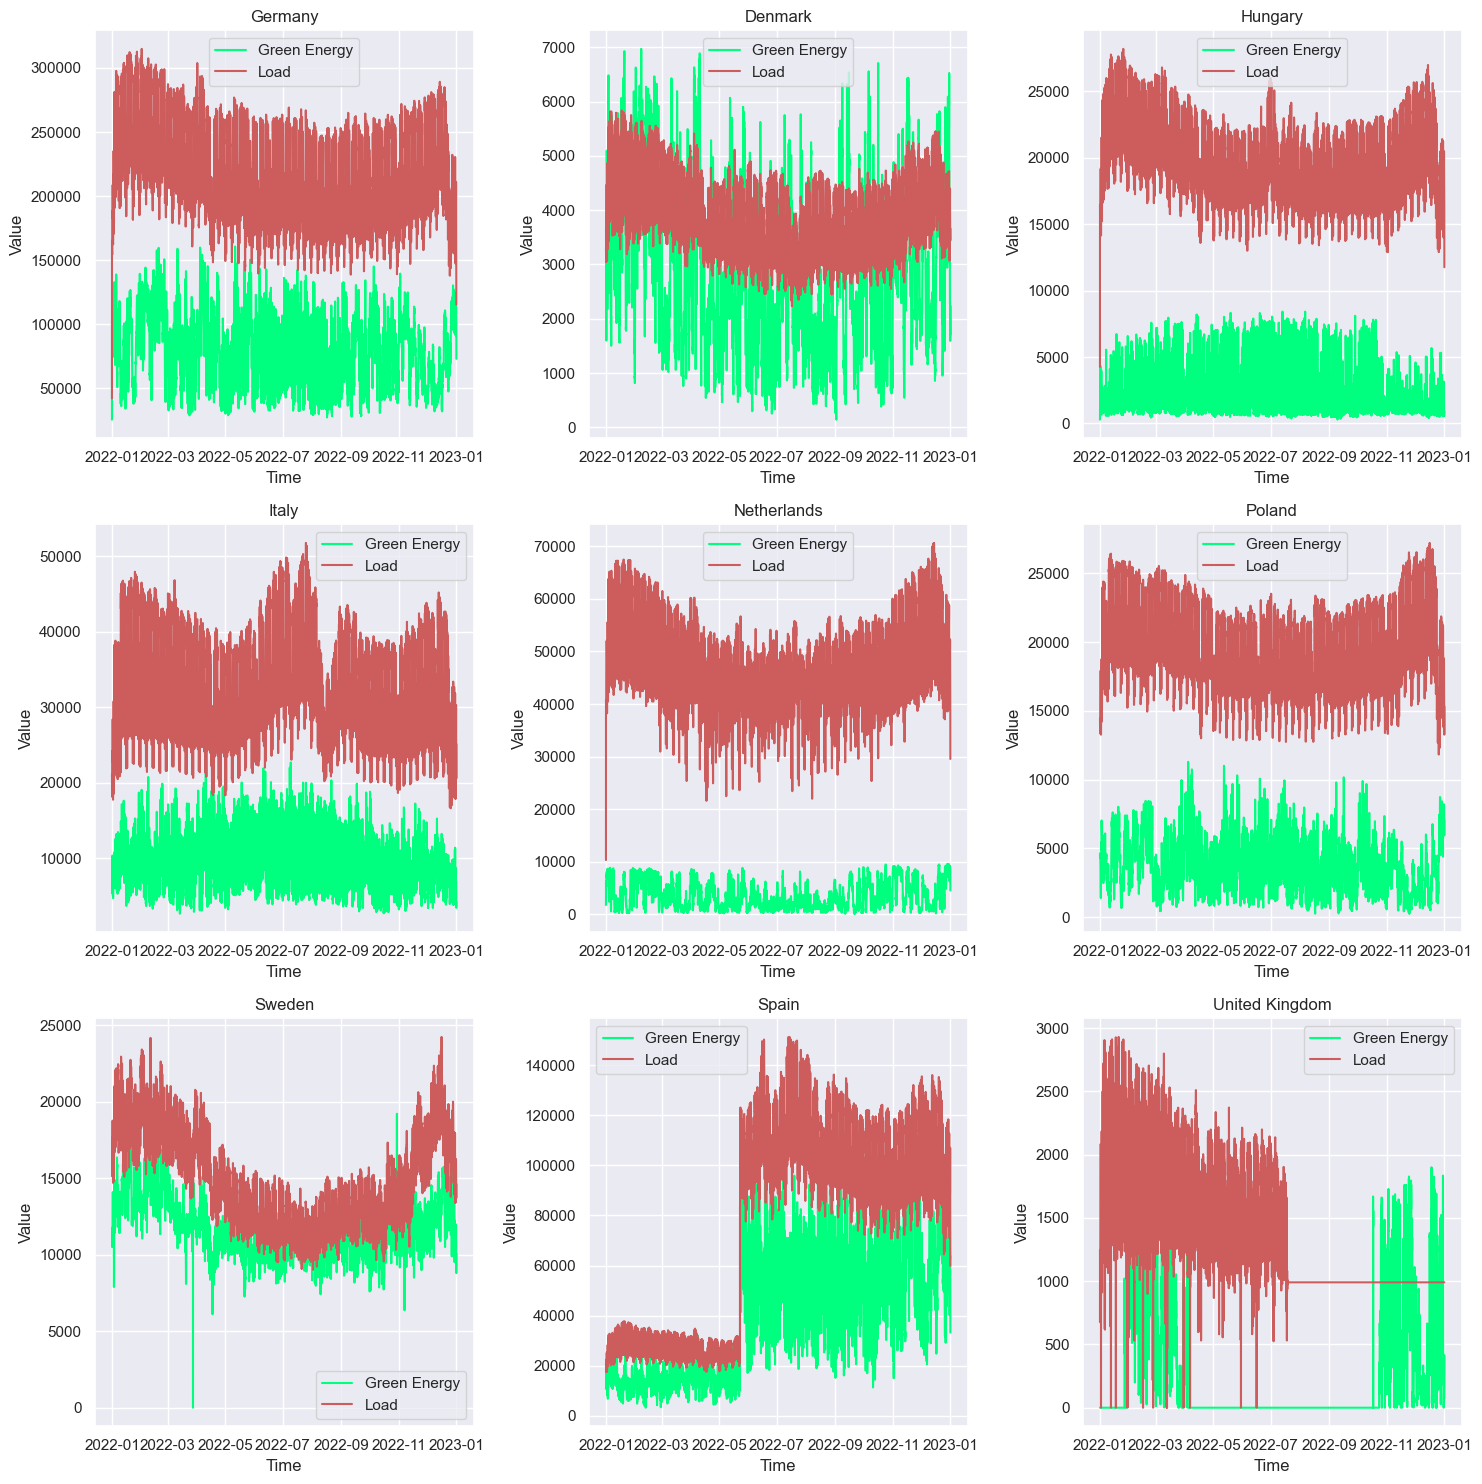

In [353]:
# Use the function to plot the time series for each country
plot_ge_load(ecof_df,country_codes)

As deteiled before, Denmark is the country with less Load energy and the oone with biggest relative Green Energy Generation

In [354]:
def plot_ge_load_comparison(df, country_codes):
    """
    Plots a comparison of the GE and Load data for each country in the DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    """

    # Define the country codes
    country_codes = country_codes

    # Reset the index of the DataFrame
    df_reset = df.reset_index()

    ge_columns = [col for col in df_reset.columns if 'GE_' in col]
    load_columns = [col for col in df_reset.columns if 'Load_' in col]

    fig, axs = plt.subplots(2, 1, figsize=(15, 10))

    # Plot GE data
    for ge_col in ge_columns:
        # Replace the country code with the full country name
        country_code = ge_col.split('_')[1]
        country_name = country_codes.get(country_code, country_code)

        sns.lineplot(data=df_reset, x='StartTime', y=ge_col, ax=axs[0], label=country_name)

    axs[0].set_title('Green Energy Comparison per Country')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('GE')

    # Plot Load data
    for load_col in load_columns:
        # Replace the country code with the full country name
        country_code = load_col.split('_')[1]
        country_name = country_codes.get(country_code, country_code)

        sns.lineplot(data=df_reset, x='StartTime', y=load_col, ax=axs[1], label=country_name)

    axs[1].set_title('Load Comparison per Country')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Load')

    plt.tight_layout()
    plt.show()

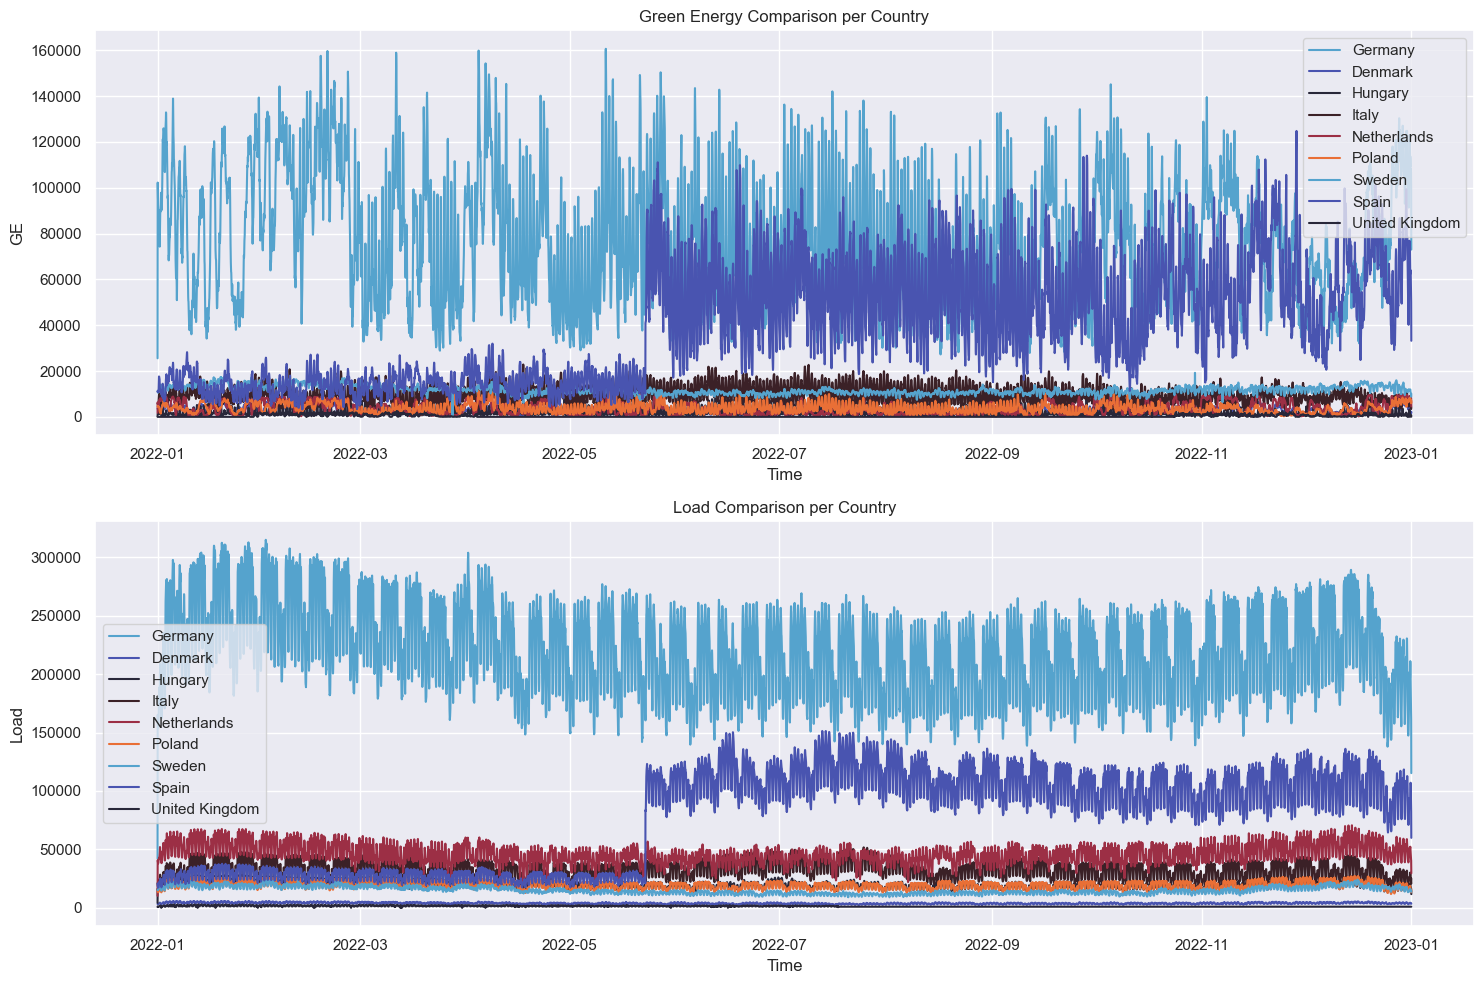

In [355]:
plot_ge_load_comparison(ecof_df,country_codes)

Even when Germany Have a larger Load of Energy, and a Larger Generation of Green Energy most of the time, in some instance Denmark is capable of outperform germany in terms of GE, even having a lot of less Load Energy.

### Model Building
We will be perform split train and test with 80/20 ratio, and leverage the power of arima using auto_arima to fine tuning the model, splitting the dataset for country and generating one model per country cappable of forecast the surplus of the next hour. Then our function will get all the results for the multiples arima models and concatenete it in the same dataframe in order to after use the make prediction funcion and obtain the country with higher surpluss in the nexts hours.

#### Train & Test Split

In [356]:
def split_train_test(df, train_ratio=0.8):
    """
    Splits a DataFrame into a training set and a test set.

    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    train_ratio (float): The proportion of the data to include in the training set.

    Returns:
    train (pandas.DataFrame): The training set.
    test (pandas.DataFrame): The test set.
    """

    # Calculate the index at which to split the DataFrame
    split_idx = int(len(df) * train_ratio)

    # Split the DataFrame
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]

    return train, test

# Use the function on your DataFrame
train, test = split_train_test(df_filled)

In [357]:
train

,GE_DE,GE_DK,GE_HU,GE_IT,GE_NE,GE_PO,GE_SE,GE_SP,GE_UK,Load_DE,Load_DK,Load_HU,Load_IT,Load_NE,Load_PO,Load_SE,Load_SP,Load_UK
StartTime,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,25558.5,3652.0,285.0,5749.0,1777.0,4641.0,11060.0,11244.0,0.0,42196.0,3314.0,4254.0,21121.0,10326.0,14438.0,15331.0,20827.0,677.00
2022-01-01 00:00:00+00:00,102228.0,3605.0,1376.0,5679.5,6384.0,4491.0,11107.0,10827.0,0.0,165125.0,3218.0,16457.0,19756.0,40706.0,13935.0,15331.0,19530.0,1244.00
2022-01-01 01:00:00+00:00,98646.0,3309.0,1526.0,5878.0,5565.5,4436.0,11036.0,11140.0,0.0,160415.0,3126.0,15426.0,18685.0,39465.0,13579.0,15270.0,18383.0,1131.00
2022-01-01 02:00:00+00:00,96781.5,3043.0,1560.0,6039.5,5662.0,4568.0,10509.0,11361.0,0.0,158035.0,3080.0,14781.0,18124.0,38923.0,13397.0,15150.0,17680.0,1091.00
2022-01-01 03:00:00+00:00,93765.0,2852.0,1287.0,5593.0,5645.0,4559.0,10770.0,11247.0,0.0,157016.0,3044.0,14630.0,18400.0,38211.0,13364.0,15387.0,17396.0,969.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-19 18:00:00+00:00,62899.0,828.0,1257.0,5878.5,7337.5,2165.0,12092.0,61588.0,0.0,230415.0,3721.0,21403.0,33929.0,52306.0,20967.0,14455.0,123944.0,990.83
2022-10-19 19:00:00+00:00,68044.5,1027.0,1334.0,5433.0,7776.0,1858.0,12103.0,60820.0,0.0,219712.0,3576.0,19881.0,30737.0,49391.0,19492.0,14156.0,116196.0,990.83
2022-10-19 20:00:00+00:00,74189.0,1255.0,1330.0,5431.0,7857.5,1537.0,11716.0,51504.0,0.0,205298.0,3472.0,18996.0,28335.0,46331.0,18162.0,13940.0,105072.0,990.83


In [358]:
test

,GE_DE,GE_DK,GE_HU,GE_IT,GE_NE,GE_PO,GE_SE,GE_SP,GE_UK,Load_DE,Load_DK,Load_HU,Load_IT,Load_NE,Load_PO,Load_SE,Load_SP,Load_UK
StartTime,,,,,,,,,,,,,,,,,,
2022-10-19 23:00:00+00:00,90463.5,1771.0,1053.0,5209.5,6149.5,1128.00,11276.00,43728.0,0.0,175241.0,3248.0,16431.0,24363.00,39629.0,16312.0,13418.00,88440.0,990.83
2022-10-20 00:00:00+00:00,92741.0,1823.0,949.0,5194.0,6121.0,1094.00,11266.00,45832.0,0.0,173505.0,3187.0,16021.0,23921.00,38634.0,16350.0,13261.00,85880.0,990.83
2022-10-20 01:00:00+00:00,93652.5,1730.0,864.0,5859.0,6000.0,1121.00,11398.00,47720.0,0.0,177254.0,3190.0,15951.0,24211.00,38467.0,16745.0,13516.00,84316.0,990.83
2022-10-20 02:00:00+00:00,93916.5,1889.0,768.0,6083.0,5976.5,1153.00,11736.00,51064.0,0.0,183285.0,3325.0,16644.0,25531.00,38608.0,17552.0,14218.00,85048.0,990.83
2022-10-20 03:00:00+00:00,91258.5,2081.0,707.0,5382.5,5626.5,1550.00,12178.00,52780.0,0.0,199931.0,3754.0,18378.0,29895.00,40633.0,20368.0,15992.00,88708.0,990.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,108172.5,1765.0,851.0,4157.0,8620.5,6959.00,10179.00,62510.0,412.0,184106.0,3713.0,17488.0,24809.00,45646.0,15211.0,14440.00,104484.0,990.83
2022-12-31 20:00:00+00:00,107809.5,1593.0,888.0,3636.0,8616.5,6910.00,9586.00,58594.0,415.0,175401.0,3579.0,17075.0,23169.00,43425.0,14641.0,14201.00,97124.0,990.83
2022-12-31 21:00:00+00:00,106675.0,1788.0,807.0,3550.0,8564.5,7054.00,9148.00,56560.0,338.0,168830.0,3520.0,16717.0,21857.00,41766.0,13977.0,13713.00,87316.0,990.83


In [90]:
def save_df_as_csv(df, filename):
    """
    Saves a DataFrame as a CSV file.

    Parameters:
    df (pandas.DataFrame): The DataFrame to save.
    filename (str): The name of the CSV file.
    """

    df.to_csv(filename)


### Saving Train & Test Sets

In [91]:
# Use the function to save your DataFrames
save_df_as_csv(train, '../data/train.csv')
save_df_as_csv(test, '../data/test.csv')

In [92]:
train = pd.read_csv('../data/train.csv', index_col='StartTime')
train.head()

,GE_DE,GE_DK,GE_HU,GE_IT,GE_NE,GE_PO,GE_SE,GE_SP,GE_UK,Load_DE,Load_DK,Load_HU,Load_IT,Load_NE,Load_PO,Load_SE,Load_SP,Load_UK
StartTime,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,25558.5,3652.0,285.0,5749.0,1777.0,4641.0,11060.0,11244.0,0.0,42196.0,3314.0,4254.0,21121.0,10326.0,14438.0,15331.0,20827.0,677.0
2022-01-01 00:00:00+00:00,102228.0,3605.0,1376.0,5679.5,6384.0,4491.0,11107.0,10827.0,0.0,165125.0,3218.0,16457.0,19756.0,40706.0,13935.0,15331.0,19530.0,1244.0
2022-01-01 01:00:00+00:00,98646.0,3309.0,1526.0,5878.0,5565.5,4436.0,11036.0,11140.0,0.0,160415.0,3126.0,15426.0,18685.0,39465.0,13579.0,15270.0,18383.0,1131.0
2022-01-01 02:00:00+00:00,96781.5,3043.0,1560.0,6039.5,5662.0,4568.0,10509.0,11361.0,0.0,158035.0,3080.0,14781.0,18124.0,38923.0,13397.0,15150.0,17680.0,1091.0
2022-01-01 03:00:00+00:00,93765.0,2852.0,1287.0,5593.0,5645.0,4559.0,10770.0,11247.0,0.0,157016.0,3044.0,14630.0,18400.0,38211.0,13364.0,15387.0,17396.0,969.0


In [93]:
test = pd.read_csv('../data/test.csv', index_col='StartTime')
test.head()

,GE_DE,GE_DK,GE_HU,GE_IT,GE_NE,GE_PO,GE_SE,GE_SP,GE_UK,Load_DE,Load_DK,Load_HU,Load_IT,Load_NE,Load_PO,Load_SE,Load_SP,Load_UK
StartTime,,,,,,,,,,,,,,,,,,
2022-10-19 23:00:00+00:00,90463.5,1771.0,1053.0,5209.5,6149.5,1128.0,11276.0,43728.0,0.0,175241.0,3248.0,16431.0,24363.0,39629.0,16312.0,13418.0,88440.0,990.83
2022-10-20 00:00:00+00:00,92741.0,1823.0,949.0,5194.0,6121.0,1094.0,11266.0,45832.0,0.0,173505.0,3187.0,16021.0,23921.0,38634.0,16350.0,13261.0,85880.0,990.83
2022-10-20 01:00:00+00:00,93652.5,1730.0,864.0,5859.0,6000.0,1121.0,11398.0,47720.0,0.0,177254.0,3190.0,15951.0,24211.0,38467.0,16745.0,13516.0,84316.0,990.83
2022-10-20 02:00:00+00:00,93916.5,1889.0,768.0,6083.0,5976.5,1153.0,11736.0,51064.0,0.0,183285.0,3325.0,16644.0,25531.0,38608.0,17552.0,14218.0,85048.0,990.83
2022-10-20 03:00:00+00:00,91258.5,2081.0,707.0,5382.5,5626.5,1550.0,12178.0,52780.0,0.0,199931.0,3754.0,18378.0,29895.0,40633.0,20368.0,15992.0,88708.0,990.83


### Surplus Function

In [94]:
# Crear un DataFrame para el surplus
def Get_Surplus_DF(df):
    surplus = pd.DataFrame(index=df.index)
    for country in ['DE', 'DK', 'HU', 'IT', 'NE', 'PO', 'SE', 'SP', 'UK']:
        surplus['Surplus_' + country] =   np.abs(df['Load_' + country] - df['GE_' + country])

    return surplus


In [105]:
train

,GE_DE,GE_DK,GE_HU,GE_IT,GE_NE,GE_PO,GE_SE,GE_SP,GE_UK,Load_DE,Load_DK,Load_HU,Load_IT,Load_NE,Load_PO,Load_SE,Load_SP,Load_UK
StartTime,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00+00:00,25558.5,3652.0,285.0,5749.0,1777.0,4641.0,11060.0,11244.0,0.0,42196.0,3314.0,4254.0,21121.0,10326.0,14438.0,15331.0,20827.0,677.00
2022-01-01 00:00:00+00:00,102228.0,3605.0,1376.0,5679.5,6384.0,4491.0,11107.0,10827.0,0.0,165125.0,3218.0,16457.0,19756.0,40706.0,13935.0,15331.0,19530.0,1244.00
2022-01-01 01:00:00+00:00,98646.0,3309.0,1526.0,5878.0,5565.5,4436.0,11036.0,11140.0,0.0,160415.0,3126.0,15426.0,18685.0,39465.0,13579.0,15270.0,18383.0,1131.00
2022-01-01 02:00:00+00:00,96781.5,3043.0,1560.0,6039.5,5662.0,4568.0,10509.0,11361.0,0.0,158035.0,3080.0,14781.0,18124.0,38923.0,13397.0,15150.0,17680.0,1091.00
2022-01-01 03:00:00+00:00,93765.0,2852.0,1287.0,5593.0,5645.0,4559.0,10770.0,11247.0,0.0,157016.0,3044.0,14630.0,18400.0,38211.0,13364.0,15387.0,17396.0,969.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-19 18:00:00+00:00,62899.0,828.0,1257.0,5878.5,7337.5,2165.0,12092.0,61588.0,0.0,230415.0,3721.0,21403.0,33929.0,52306.0,20967.0,14455.0,123944.0,990.83
2022-10-19 19:00:00+00:00,68044.5,1027.0,1334.0,5433.0,7776.0,1858.0,12103.0,60820.0,0.0,219712.0,3576.0,19881.0,30737.0,49391.0,19492.0,14156.0,116196.0,990.83
2022-10-19 20:00:00+00:00,74189.0,1255.0,1330.0,5431.0,7857.5,1537.0,11716.0,51504.0,0.0,205298.0,3472.0,18996.0,28335.0,46331.0,18162.0,13940.0,105072.0,990.83


In [95]:
train_surplus = Get_Surplus_DF(train)
train_surplus

,Surplus_DE,Surplus_DK,Surplus_HU,Surplus_IT,Surplus_NE,Surplus_PO,Surplus_SE,Surplus_SP,Surplus_UK
StartTime,,,,,,,,,
2021-12-31 23:00:00+00:00,16637.5,338.0,3969.0,15372.0,8549.0,9797.0,4271.0,9583.0,677.00
2022-01-01 00:00:00+00:00,62897.0,387.0,15081.0,14076.5,34322.0,9444.0,4224.0,8703.0,1244.00
2022-01-01 01:00:00+00:00,61769.0,183.0,13900.0,12807.0,33899.5,9143.0,4234.0,7243.0,1131.00
2022-01-01 02:00:00+00:00,61253.5,37.0,13221.0,12084.5,33261.0,8829.0,4641.0,6319.0,1091.00
2022-01-01 03:00:00+00:00,63251.0,192.0,13343.0,12807.0,32566.0,8805.0,4617.0,6149.0,969.00
...,...,...,...,...,...,...,...,...,...
2022-10-19 18:00:00+00:00,167516.0,2893.0,20146.0,28050.5,44968.5,18802.0,2363.0,62356.0,990.83
2022-10-19 19:00:00+00:00,151667.5,2549.0,18547.0,25304.0,41615.0,17634.0,2053.0,55376.0,990.83
2022-10-19 20:00:00+00:00,131109.0,2217.0,17666.0,22904.0,38473.5,16625.0,2224.0,53568.0,990.83


In [96]:
test_surplus = Get_Surplus_DF(test)
test_surplus

,Surplus_DE,Surplus_DK,Surplus_HU,Surplus_IT,Surplus_NE,Surplus_PO,Surplus_SE,Surplus_SP,Surplus_UK
StartTime,,,,,,,,,
2022-10-19 23:00:00+00:00,84777.5,1477.0,15378.0,19153.50,33479.5,15184.00,2142.0,44712.0,990.83
2022-10-20 00:00:00+00:00,80764.0,1364.0,15072.0,18727.00,32513.0,15256.00,1995.0,40048.0,990.83
2022-10-20 01:00:00+00:00,83601.5,1460.0,15087.0,18352.00,32467.0,15624.00,2118.0,36596.0,990.83
2022-10-20 02:00:00+00:00,89368.5,1436.0,15876.0,19448.00,32631.5,16399.00,2482.0,33984.0,990.83
2022-10-20 03:00:00+00:00,108672.5,1673.0,17671.0,24512.50,35006.5,18818.00,3814.0,35928.0,990.83
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,75933.5,1948.0,16637.0,20652.00,37025.5,8252.00,4261.0,41974.0,578.83
2022-12-31 20:00:00+00:00,67591.5,1986.0,16187.0,19533.00,34808.5,7731.00,4615.0,38530.0,575.83
2022-12-31 21:00:00+00:00,62155.0,1732.0,15910.0,18307.00,33201.5,6923.00,4565.0,30756.0,652.83


### Min Max Scaler

In [97]:
from sklearn.preprocessing import MinMaxScaler

# Función para escalar un DataFrame
def scale_data(df):
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_scaled, scaler

# Función para desescalar un DataFrame
def descale_data(df_scaled, scaler):
    df = pd.DataFrame(scaler.inverse_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index)
    return df


In [98]:
strain_surplus, scaler1 = scale_data(train_surplus)
stest_surplus, scaler2 = scale_data(test_surplus)

#### Prophets Models for Surplus Forecasting

In [103]:
# Parameters Grid
param_grid = {
    'changepoint_prior_scale': [0.1, 0.3]
    }

# Models Dict
models = {}

# Index as DateTime
strain_surplus.index = pd.to_datetime(strain_surplus.index)


# Drop Time Zone
if strain_surplus.index.tz is not None:
    strain_surplus.index = strain_surplus.index.tz_localize(None)

strain_surplus.index.name = 'ds'

# Train a Prophet Model for Each Country
for country in tqdm(['DE', 'DK', 'HU', 'IT', 'NE', 'PO', 'SE', 'SP', 'UK']):
    # Generar todas las combinaciones de parámetros
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Almacenar los RMSEs para cada conjunto de parámetros aquí

    # Cross-Validation
    for params in tqdm(all_params):
        m = Prophet(**params).fit(strain_surplus[['Surplus_' + country]].reset_index().rename(columns={'Surplus_' + country: 'y'}))  # Ajustar el modelo con los parámetros dados
        strain_surplus_cv = cross_validation(m, horizon='5 days', parallel="processes")
        strain_surplus_p = performance_metrics(strain_surplus_cv, rolling_window=1)
        rmses.append(strain_surplus_p['rmse'].values[0])

    # Best Hyperparameters
    best_params = all_params[np.argmin(rmses)]
    
    # Tune the Models with the Best HP
    model = Prophet(**best_params)
    model.fit(strain_surplus[['Surplus_' + country]].reset_index().rename(columns={'Surplus_' + country: 'y'}))
    
    models[country] = model


  0%|          | 0/9 [00:00<?, ?it/s]14:52:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/9 [02:36<?, ?it/s]


KeyboardInterrupt: 

In [104]:
test_surplus

,Surplus_DE,Surplus_DK,Surplus_HU,Surplus_IT,Surplus_NE,Surplus_PO,Surplus_SE,Surplus_SP,Surplus_UK
StartTime,,,,,,,,,
2022-10-19 23:00:00+00:00,84777.5,1477.0,15378.0,19153.50,33479.5,15184.00,2142.0,44712.0,990.83
2022-10-20 00:00:00+00:00,80764.0,1364.0,15072.0,18727.00,32513.0,15256.00,1995.0,40048.0,990.83
2022-10-20 01:00:00+00:00,83601.5,1460.0,15087.0,18352.00,32467.0,15624.00,2118.0,36596.0,990.83
2022-10-20 02:00:00+00:00,89368.5,1436.0,15876.0,19448.00,32631.5,16399.00,2482.0,33984.0,990.83
2022-10-20 03:00:00+00:00,108672.5,1673.0,17671.0,24512.50,35006.5,18818.00,3814.0,35928.0,990.83
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,75933.5,1948.0,16637.0,20652.00,37025.5,8252.00,4261.0,41974.0,578.83
2022-12-31 20:00:00+00:00,67591.5,1986.0,16187.0,19533.00,34808.5,7731.00,4615.0,38530.0,575.83
2022-12-31 21:00:00+00:00,62155.0,1732.0,15910.0,18307.00,33201.5,6923.00,4565.0,30756.0,652.83


In [ ]:
from joblib import dump
def save_models(models, path='../models/'):
    for country, model in models.items():
        # Guardar el modelo en un archivo .joblib
        dump(model, f'{path}prophet_{country}.joblib')
    print(f'Models Saved Succefully')

In [ ]:
save_models(models)

Models Saved Succefully


In [ ]:
def predict_surplus(test_surplus, n_periods):
    # Crear un DataFrame para las predicciones
    predictions = pd.DataFrame()
    
    # Hacer predicciones para cada país
    for country in ['DE', 'DK', 'HU', 'IT', 'NE', 'PO', 'SE', 'SP', 'UK']:
        # Crear un DataFrame para las predicciones futuras
        future = models[country].make_future_dataframe(periods=n_periods, freq='H')
        # Realizar la predicción
        forecast = models[country].predict(future)
        # Añadir las predicciones al DataFrame de predicciones
        predictions['Surplus_' + country] = forecast['yhat'].tail(n_periods).values
    
    # Crear el índice de tiempo para las predicciones
    start_date = pd.to_datetime('2022-10-19 23:00:00+00:00')
    predictions['StartTime'] = pd.date_range(start=start_date, periods=n_periods, freq='H')
    predictions.set_index('StartTime')
    return predictions




In [ ]:
n_periods = 442
predictions = predict_surplus(test_surplus, n_periods)

In [ ]:
predictions

,Surplus_DE,Surplus_DK,Surplus_HU,Surplus_IT,Surplus_NE,Surplus_PO,Surplus_SE,Surplus_SP,Surplus_UK
StartTime,,,,,,,,,
2022-10-19 23:00:00+00:00,123791.781865,895.580626,16435.173310,21830.244594,40258.883070,13911.478183,1524.057522,55939.515359,848.621860
2022-10-20 00:00:00+00:00,118580.060715,854.309624,15657.760286,21147.443708,38991.443486,13624.615460,1438.128318,54463.424229,775.888377
2022-10-20 01:00:00+00:00,117995.226293,859.762513,15367.490219,21328.438337,38178.118844,13719.229658,1411.299952,53533.541555,734.728025
2022-10-20 02:00:00+00:00,123709.910284,944.620257,15794.411621,22378.373380,38231.467692,14325.173653,1561.807086,54099.862993,717.907686
2022-10-20 03:00:00+00:00,134882.966769,1090.392823,16742.755936,24046.731288,39427.642985,15312.691469,1911.879257,56687.489167,722.552084
...,...,...,...,...,...,...,...,...,...
2022-11-07 04:00:00+00:00,128834.974813,831.328990,16076.711693,22405.988410,39857.163803,14518.529369,2107.696589,53669.267009,638.064104
2022-11-07 05:00:00+00:00,141187.775427,920.771038,16358.832184,23990.851034,42093.301489,15200.837956,2490.492430,56571.385720,715.733580
2022-11-07 06:00:00+00:00,147983.706476,920.937543,15735.327772,24586.968673,43268.241548,15237.599625,2675.887380,56250.140602,832.191932


In [ ]:
test_surplus

,Surplus_DE,Surplus_DK,Surplus_HU,Surplus_IT,Surplus_NE,Surplus_PO,Surplus_SE,Surplus_SP,Surplus_UK
StartTime,,,,,,,,,
2022-10-19 23:00:00+00:00,84777.5,1477.0,15378.0,19153.50,33479.5,15184.00,2142.0,44712.0,990.83
2022-10-20 00:00:00+00:00,80764.0,1364.0,15072.0,18727.00,32513.0,15256.00,1995.0,40048.0,990.83
2022-10-20 01:00:00+00:00,83601.5,1460.0,15087.0,18352.00,32467.0,15624.00,2118.0,36596.0,990.83
2022-10-20 02:00:00+00:00,89368.5,1436.0,15876.0,19448.00,32631.5,16399.00,2482.0,33984.0,990.83
2022-10-20 03:00:00+00:00,108672.5,1673.0,17671.0,24512.50,35006.5,18818.00,3814.0,35928.0,990.83
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,75933.5,1948.0,16637.0,20652.00,37025.5,8252.00,4261.0,41974.0,578.83
2022-12-31 20:00:00+00:00,67591.5,1986.0,16187.0,19533.00,34808.5,7731.00,4615.0,38530.0,575.83
2022-12-31 21:00:00+00:00,62155.0,1732.0,15910.0,18307.00,33201.5,6923.00,4565.0,30756.0,652.83


In [ ]:
# Calcular el MAE y el MSE
mae = mean_absolute_error(test_surplus[:442], predictions)
print(f"MAE: {mae}")

MAE: 5066.874141565645


In [ ]:
import json

def find_max_surplus_country(predictions):
    country_codes_num = {
    'Surplus_SP': 0, # Spain
    'Surplus_UK': 1, # United Kingdom
    'Surplus_DE': 2, # Germany
    'Surplus_DK': 3, # Denmark
    'Surplus_HU': 5, # Hungary
    'Surplus_SE': 4, # Sweden
    'Surplus_IT': 6, # Italy
    'Surplus_PO': 7, # Poland
    'Surplus_NE': 8 # Netherlands
}
    # Encontrar el país con el mayor surplus en cada hora
    max_surplus_country = predictions.idxmax(axis=1)

    # Reemplazar los nombres de los países por los códigos numéricos
    max_surplus_country = max_surplus_country.replace(country_codes_num)

    # Convertir los índices a números enteros
    max_surplus_country.index = range(len(max_surplus_country))

    # Crear un diccionario para almacenar los resultados
    results = {'target': max_surplus_country.to_dict()}

    # Guardar los resultados en un archivo JSON
    with open('max_surplus_country.json', 'w') as f:
        json.dump(results, f)

    return results

In [ ]:
find_max_surplus_country(predictions)

In [85]:
import matplotlib.pyplot as plt

def plot_predictions(test, predictions):
    # Diccionario de códigos de países
    country_codes = {
        'SP': 'Spain',
        'UK': 'United Kingdom',
        'DE': 'Germany',
        'DK': 'Denmark',
        'HU': 'Hungary',
        'SE': 'Sweden',
        'IT': 'Italy',
        'PO': 'Poland',
        'NE': 'Netherlands'
    }
    test.index = pd.to_datetime(test.index)
    predictions.index = pd.to_datetime(predictions.index)

    # Crear una figura con subplots
    fig, axs = plt.subplots(len(country_codes), 1, figsize=(10, 6*len(country_codes)))
    
    # Para cada país
    for i, (code, country) in enumerate(country_codes.items()):
        # Extraer la serie de tiempo real y predicha
        real = test['Surplus_' + code]
        predicted = predictions['Surplus_' + code]
        
        # Trazar la serie de tiempo real y predicha en el subplot correspondiente
        axs[i].plot(real.index, real, label='Real')
        axs[i].plot(predicted.index, predicted, label='Predicted')
        
        # Añadir título y etiquetas al subplot
        axs[i].set_title('Green Energy Surplus for ' + country)
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Surplus')
        axs[i].legend()
    
    # Ajustar el espacio entre subplots
    plt.tight_layout()
    
    # Mostrar la figura
    plt.show()


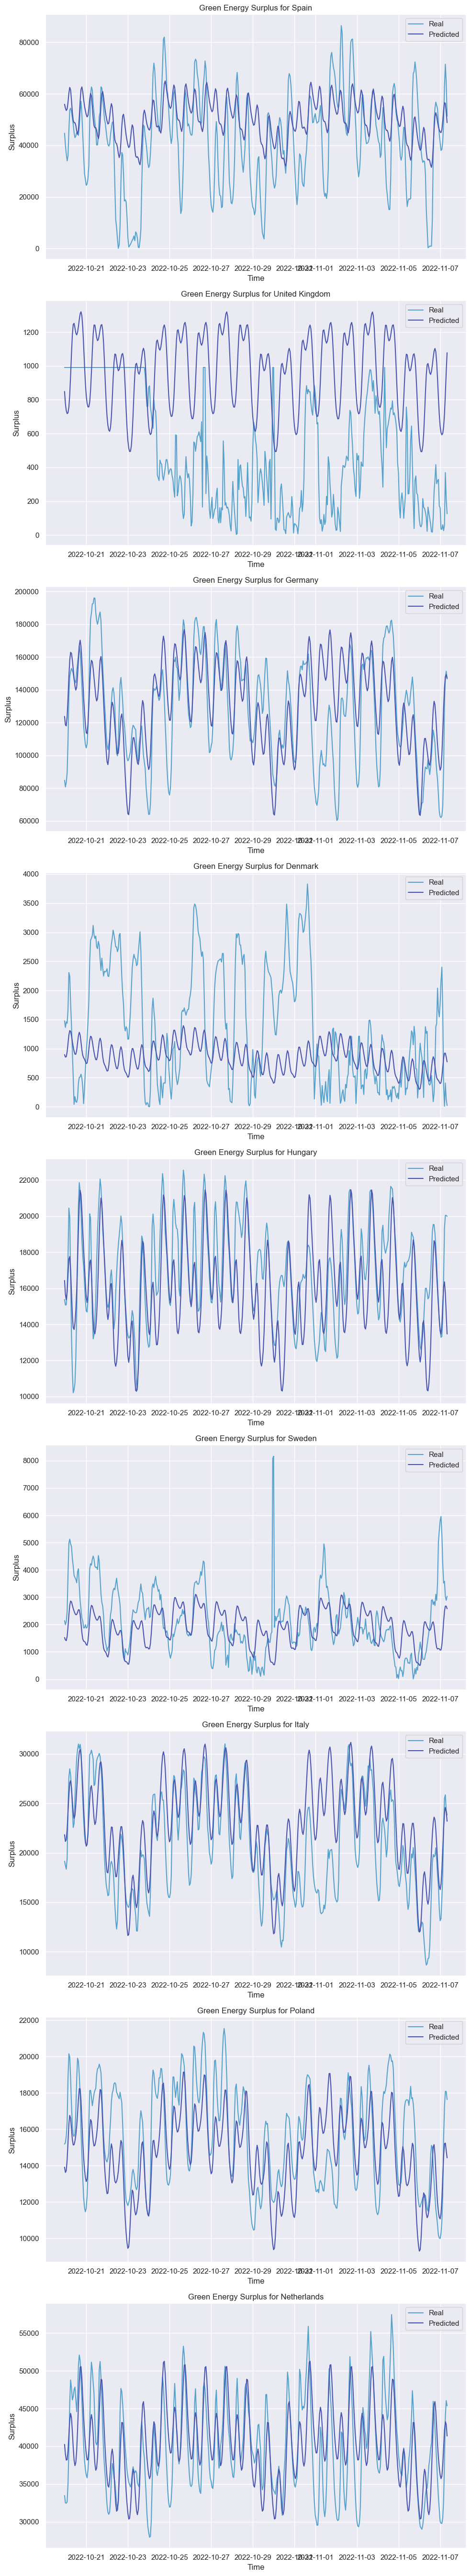

In [86]:
plot_predictions(test_surplus[:442], predictions)

In [81]:
find_max_surplus_country(predictions)

{'target': {0: 2,
  1: 2,
  2: 2,
  3: 2,
  4: 2,
  5: 2,
  6: 2,
  7: 2,
  8: 2,
  9: 2,
  10: 2,
  11: 2,
  12: 2,
  13: 2,
  14: 2,
  15: 2,
  16: 2,
  17: 2,
  18: 2,
  19: 2,
  20: 2,
  21: 2,
  22: 2,
  23: 2,
  24: 2,
  25: 2,
  26: 2,
  27: 2,
  28: 2,
  29: 2,
  30: 2,
  31: 2,
  32: 2,
  33: 2,
  34: 2,
  35: 2,
  36: 2,
  37: 2,
  38: 2,
  39: 2,
  40: 2,
  41: 2,
  42: 2,
  43: 2,
  44: 2,
  45: 2,
  46: 2,
  47: 2,
  48: 2,
  49: 2,
  50: 2,
  51: 2,
  52: 2,
  53: 2,
  54: 2,
  55: 2,
  56: 2,
  57: 2,
  58: 2,
  59: 2,
  60: 2,
  61: 2,
  62: 2,
  63: 2,
  64: 2,
  65: 2,
  66: 2,
  67: 2,
  68: 2,
  69: 2,
  70: 2,
  71: 2,
  72: 2,
  73: 2,
  74: 2,
  75: 2,
  76: 2,
  77: 2,
  78: 2,
  79: 2,
  80: 2,
  81: 2,
  82: 2,
  83: 2,
  84: 2,
  85: 2,
  86: 2,
  87: 2,
  88: 2,
  89: 2,
  90: 2,
  91: 2,
  92: 2,
  93: 2,
  94: 2,
  95: 2,
  96: 2,
  97: 2,
  98: 2,
  99: 2,
  100: 2,
  101: 2,
  102: 2,
  103: 2,
  104: 2,
  105: 2,
  106: 2,
  107: 2,
  108: 2,
  109: 2,


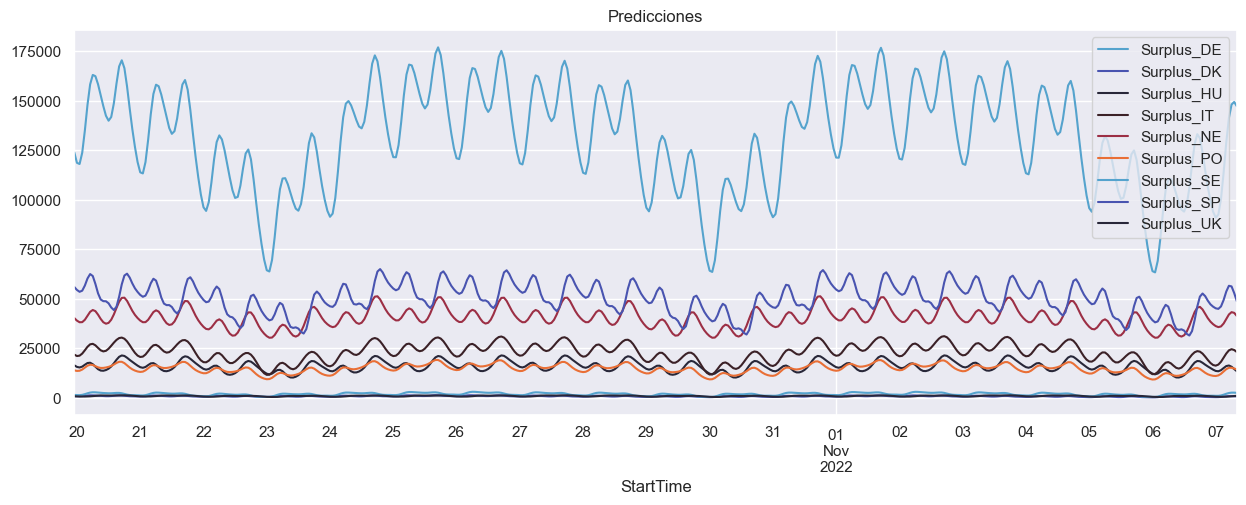

In [79]:
fig, ax = plt.subplots(figsize=(15, 5))
predictions.plot(ax=ax)
plt.title('Predicciones')
plt.show()

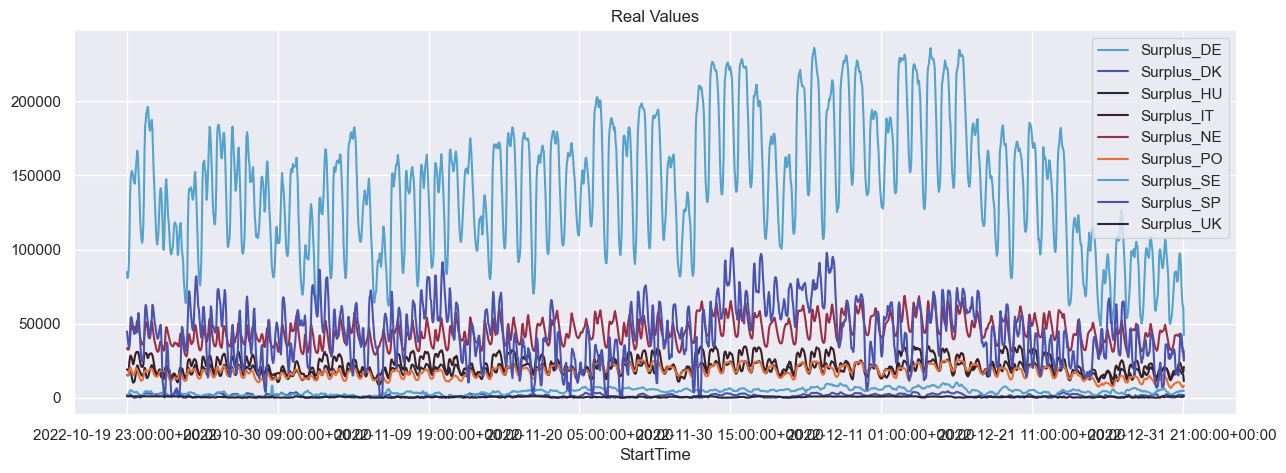

In [80]:
fig, ax = plt.subplots(figsize=(15, 5))
test_surplus.plot(ax=ax)
plt.title('Real Values')
plt.show()